# Capao Urban Rate

This notebook aims to estimate the current urban growth rate for the place: Vale do Capão, Palmeiras, BA, Brasil. By using Google Earth satellite images and analyzing RGB pixel data, we can determine the growth rate in areas featuring houses, roads, construction sites, or where forests have been cleared for humans uses. For this case study, we have chosen COPERNICUS satellite images.

In [ ]:
import ee
from utils.contants import PROJECT
import geemap as geemap
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

ee.Authenticate()
ee.Initialize(project=PROJECT)
geemap.ee_initialize()

geo_point = ee.Geometry.Point([-41.501150593949305,-12.609558240448216])

image = (
  ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterBounds(geo_point)
    .filterDate('2023-01-01', '2023-12-01')
    .sort('CLOUDY_PIXEL_PERCENTAGE')
    .first()
)
# B2 - Blue | B3 - Green |  B4 - Red
bands = ['B2', 'B3', 'B4']

# Pre processing

In [ ]:
df = pd.read_csv('./data/capao_urban_rate.csv')

dataset = df[['system:index', 'B2', 'B3', 'B4']].copy()
dataset = dataset.replace(regex=r'1_\d+_\d+', value=0) # Urban Class 0
dataset = dataset.replace(regex=r'2_\d+_\d+', value=1) # Urban Class 1
dataset.rename(columns={'system:index': 'class'}, inplace=True)
dataset[60:90]

## Data Clusters

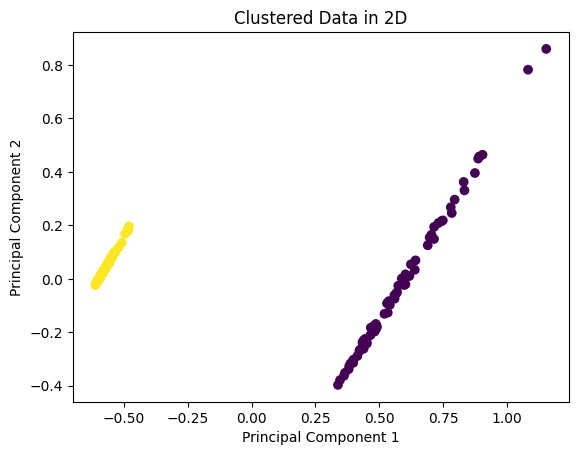

In [11]:
# Normalizing the data to be in the range (0, 1)
scaler = MinMaxScaler()
dataset_normalized = scaler.fit_transform(dataset)

# PCA to reduce dimensions from 3 to 2
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(dataset_normalized)

# K-means clustering
kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit_predict(data_reduced)

# Visualize clusters
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=clusters, cmap='viridis', marker='o')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustered Data in 2D')
plt.show()

## Data Analysis

In [12]:
dataset['Cluster'] = clusters
dataset[60:90]

,class,B2,B3,B4,Cluster
60,0,738,1080,1106,0
61,0,702,1108,1192,0
62,0,1206,1874,2866,0
63,0,625,948,1120,0
64,0,543,930,1096,0
65,0,485,854,1158,0
66,0,411,658,790,0
67,0,889,1182,1650,0
68,0,602,976,1332,0
69,0,534,784,897,0


# Map view

In [ ]:
map = geemap.Map(center=[-12.609558240448216,-41.501150593949305], zoom=15)
# Adjust this value to increase or decrease the contrast
gamma = 3.5  
map.add_layer(
  image,  
  {"bands": bands,  min: 0, max: 2000, "gamma": gamma},
  "true colors"
)
# Display the map
map